In [1]:
import numpy as np
import osqp
import matplotlib.pyplot as plt
from scipy import sparse
# import control as ct
from casadi import *
import dpilqr
import itertools
import cvxpy as cp

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from solvers.util import (
    compute_pairwise_distance,
    compute_pairwise_distance_nd_Sym,
    define_inter_graph_threshold,
    distance_to_goal,
    split_graph, 
    generate_f,
    generate_f_human_drone,
    objective,
    generate_min_max_input,
    generate_min_max_state
)

In [4]:
def linear_kinodynamics(dt,n_agent):
    #Decision vector is a = [a_x, a_y, a_z]
    #State vector is X = [p_x, p_y, p_z, v_x, v_y, v_z]
    #Discretization time step is dt
    A_tot = np.zeros((6*n_agent, 6*n_agent))
    B_tot = np.zeros((6*n_agent, 3*n_agent))
    A = np.array([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0 , dt ,0],\
                           [0, 0, 1, 0, 0 , dt],\
                           [0, 0, 0, 1, 0 ,0],\
                           [0, 0, 0, 0, 1 ,0],\
                           [0, 0, 0, 0, 0, 1]])
    B = np.array([[dt**2/2, 0, 0],\
                           [0, dt**2/2, 0],\
                           [0, 0, dt**2/2],\
                           [dt, 0, 0 ],\
                           [0, dt , 0],\
                           [0, 0, dt]])

    for i in range(n_agent):
        A_tot[i*6:(i+1)*6,i*6:(i+1)*6] = A
        B_tot[i*6:(i+1)*6,i*3:(i+1)*3] = B
        
    
    return A_tot, B_tot

In [5]:
from solvers import util
from multiprocessing import Process, Pipe
import cvxpy as cp

#### Using IPOPT for local constraint problems (using Casadi pcakage):

In [6]:
from casadi import *
import casadi as cs

### Optimize over fixed horizon (not shifting)

In [8]:
"""Define constants"""
n_states = 6
n_inputs = 3
n_agents = 3
nx = n_states*n_agents
nu = n_inputs*n_agents
x0,xr = util.paper_setup_3_quads()
N = n_agents
T = 20
Q = np.diag([5., 5., 5., 1., 1., 1.]*N)
Qf = Q*500
R = 0.1*np.eye(N*n_inputs)
radius = 0.35
Ad, Bd = linear_kinodynamics(0.1, N)


f_list = {}
d = {} 
states = {}

for id in range(N):
    d["opti_{0}".format(id)] = Opti()
    
    #Augmented state : Y = (x(0),x(1),...,x(N),u(0),...,u(N-1))
    
    states["Y_{0}".format(id)] = d[f"opti_{id}"].variable((T+1)*nx + T* nu)
    cost = 0
  
    #Quadratic tracking cost
      
    for t in range(T):
        for idx in range(nx):
            cost += (states[f"Y_{id}"][:(T+1)*nx][t*nx:(t+1)*nx][idx]-xr[idx]) *  \
            Q[idx,idx]* (states[f"Y_{id}"][:(T+1)*nx][t*nx:(t+1)*nx][idx]-xr[idx]) 
        for idu in range(nu):
            cost += (states[f"Y_{id}"][(T+1)*nx:][t*nu:(t+1)*nu][idu]) *  \
            R[idu,idu] * (states[f"Y_{id}"][(T+1)*nx:][t*nu:(t+1)*nu][idu])
    
    for idf in range(nx):
        cost += (states[f"Y_{id}"][:(T+1)*nx][T*nx:(T+1)*nx][idf] - xr[idf]) * \
        Qf[idf,idf] * (states[f"Y_{id}"][:(T+1)*nx][T*nx:(T+1)*nx][idf] - xr[idf])

    # f_list.append(cost)
    f_list["cost_{0}".format(id)] = cost

def run_worker(agent_id, cost, pipe):
    n_states = 6
    xbar = d[f"opti_{agent_id}"].parameter((T+1)*nx + T*nu)
    d[f"opti_{agent_id}"].set_value(xbar, cs.GenDM_zeros((T+1)*nx + T*nu,1))    
    
    u = d[f"opti_{agent_id}"].parameter((T+1)*nx + T*nu)
    d[f"opti_{agent_id}"].set_value(u, cs.GenDM_zeros((T+1)*nx + T*nu,1))
    
    result = {}
    #This is the scaled Lagrange multiplier

    rho = 5
    cost += (rho/2)*sumsqr(states[f"Y_{agent_id}"] - xbar + u)
    
    # ADMM loop
    
    iter = 0
    while True:
        try:
               
            coll_cost = 0
            smooth_trj_cost = 0
            for k in range(T):
            
                d[f"opti_{agent_id}"].subject_to(states[f"Y_{agent_id}"][:(T+1)*nx][(k+1)*nx:(k+2)*nx] \
                                == Ad @ states[f"Y_{agent_id}"][:(T+1)*nx][k*nx:(k+1)*nx] \
                                    + Bd @ states[f"Y_{agent_id}"][(T+1)*nx:][k*nu:(k+1)*nu])

                d[f"opti_{agent_id}"].subject_to(states[f"Y_{agent_id}"][(T+1)*nx:][k*nu:(k+1)*nu] <= np.tile(np.array([3, 3, 3]),(N,)).reshape(-1,1))
                d[f"opti_{agent_id}"].subject_to(np.tile(np.array([-3, -3, -3]),(N,)).reshape(-1,1) <= states[f"Y_{agent_id}"][(T+1)*nx:][k*nu:(k+1)*nu])
            
                #Pair-wise Euclidean distance between each pair of agents
                distances = util.compute_pairwise_distance_nd_Sym(states[f"Y_{agent_id}"][:(T+1)*nx][k*nx:(k+1)*nx],[6,6,6], [3,3,3])
                #Collision avoidance cost
                for dist in distances:
                    coll_cost += fmin(0,(dist - 2*radius))**2 * 500

                #Smoothing term
                for ind in range(nx):
                    smooth_trj_cost += (states[f"Y_{agent_id}"][:(T+1)*nx][(k+1)*nx:(k+2)*nx][ind]-\
                                        states[f"Y_{agent_id}"][:(T+1)*nx][k*nx:(k+1)*nx][ind])**2
                
             
            d[f"opti_{agent_id}"].subject_to(states[f"Y_{agent_id}"][0:nx] == x0) 
                    
            d[f"opti_{agent_id}"].minimize(cost + coll_cost/n_agents + smooth_trj_cost)
            
            d[f"opti_{agent_id}"].solver("ipopt")
            
            
            
            sol = d[f"opti_{agent_id}"].solve()
            # result[f"solution_{0}".format(agent_id)] = sol
            
            # print(f'paramete xbar has value {sol.value(xbar)}')
            # print(f'parameter u has value {sol.value(u)}')
             
            pipe.send(sol.value(states[f"Y_{agent_id}"]))
           
            
            d[f"opti_{agent_id}"].set_value(xbar, pipe.recv()) #receive the averaged result from the main process.
            d[f"opti_{agent_id}"].set_value(u, sol.value( u + states[f"Y_{agent_id}"] - xbar))

            iter += 1
            print(f'Current iteration is {iter}')
            
            d[f"opti_{agent_id}"].subject_to()
            
            d[f"opti_{agent_id}"].set_initial(sol.value_variables())
            
        except EOFError:
            print("Connection closed.")
            break
                
    

pipes = []
procs = []
for i in range(N):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_worker, args=(i, f_list[f"cost_{i}"], remote))]
    procs[-1].start()

# MAX_ITER = 10
MAX_ITER = 1
solution_list = []
iter = 0
for i in range(MAX_ITER):
    # Gather and average xi

    xbar = sum(pipe.recv() for pipe in pipes)/N
    # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

    solution_list.append(xbar)
    # print(f'average of xbar is {np.mean(xbar)}\n')

    # Scatter xbar
    for pipe in pipes:
        pipe.send(xbar)
        
    if np.all(distance_to_goal(solution_list[-1][:(T+1)*nx].reshape((T+1,nx))[-1], xr.flatten(), 3, 6) < 0.1):
        break
    
    iter += 1

[p.terminate() for p in procs]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    10098
Number of nonzeros in inequality constraint Jacobian.:      360
Number of nonzeros in Lagrangian Hessian.............:     1638

Total number of variables............................:      558
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      378
Total number of inequality c

[None, None, None]

In [9]:
x_trj_converged = solution_list[-1][:(T+1)*nx].reshape((T+1,nx))

/home/randychen233/projects/ICON_lab/dp-ilqr/dpilqr/graphics.py:130: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Xi[:, 0], Xi[:, 1], Xi[:, 2], c=c, lw=2)


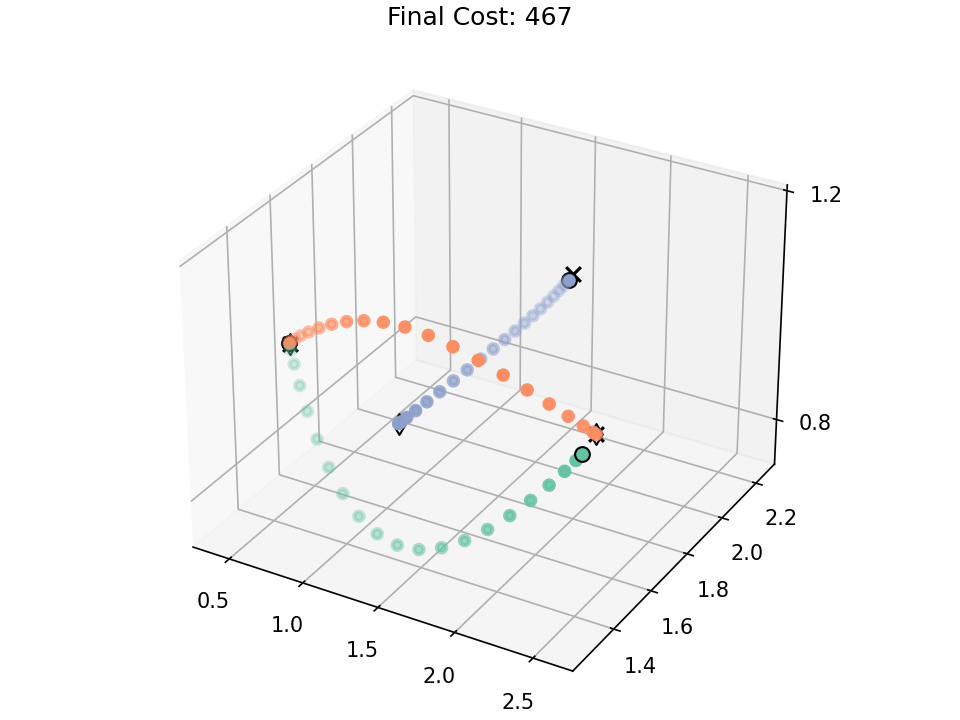

In [10]:
%matplotlib ipympl
plt.figure(dpi=150)
dpilqr.plot_solve(x_trj_converged, 466.656, xr, [6,6,6], True, 3)
plt.gca().set_zticks([0.8,1.2], minor=False)

# plt.savefig('ADMM_IPOPT_trial.png')
#Simulation over a fixed horiozn

In [11]:
dpilqr.distance_to_goal(x_trj_converged[-1], xr.flatten(), 3, 6, 3)

array([0.069, 0.041, 0.022])

In [12]:
x_trj_converged[-1].shape

(18,)

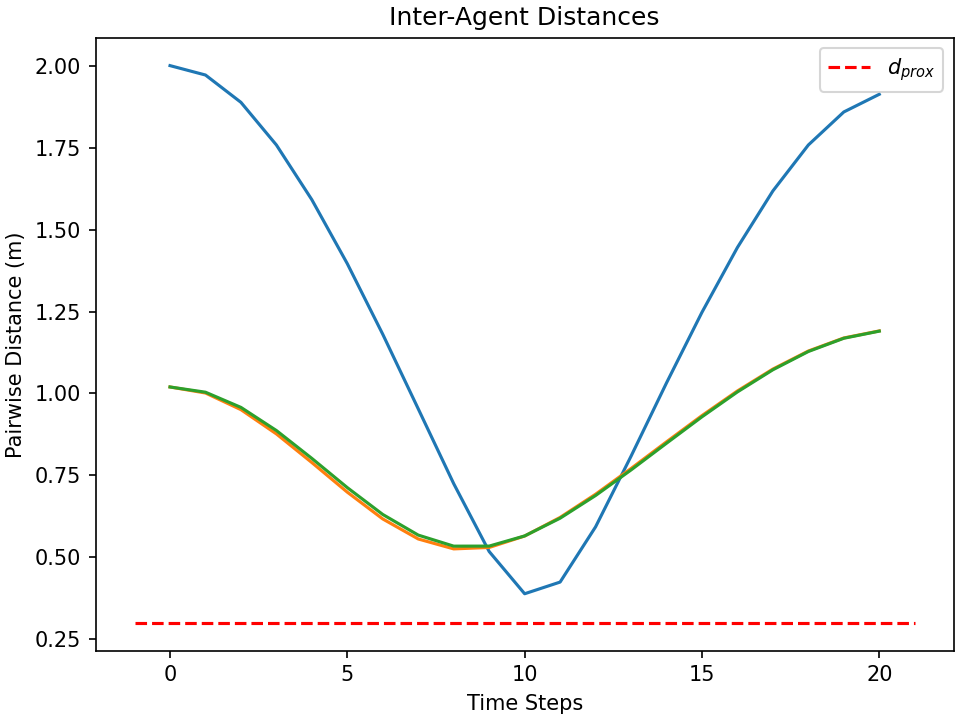

In [13]:
plt.figure(dpi=150)
dpilqr.plot_pairwise_distances(x_trj_converged,[6,6,6],[3,3,3],0.3)

In [14]:
x_dims = [6,6,6]
n_dims = [3,3,3]
ids = [100+n for n in range(3)]

In [15]:
radius

0.35

### ADMM with only consensus constraints (toy example)

In [10]:
n_states = 6
n_inputs = 3
n_agents = 3
nx = n_states*n_agents
nu = n_inputs*n_agents
x0,xr = util.paper_setup_3_quads()
N = n_agents
T = 15
Q = sparse.diags([5., 5., 5., 1., 1., 1.]*N)
Qf = Q*500
R = 0.1*sparse.eye(N*n_inputs)

# x_trj_var = cp.reshape(y_state[0:(T+1)*nx],[T+1, nx])
# u_trj_var = cp.reshape(y_state[(T+1)*nx:], [T, nu])
f_list = []
for id in range(N):
    y_state = cp.Variable((((T+1)*nx + T * nu, 1)))
    cost = 0
    for t in range(T):
        #Quadratic tracking cost
        # cost += cp.quad_form(cp.reshape(y_state[:(T+1)*nx],[T+1, nx])[t,:]-xr.flatten(),Q) + \
        # cp.quad_form(cp.reshape(y_state[(T+1)*nx:], [T, nu])[t,:],R)
        cost += cp.quad_form(y_state[:(T+1)*nx][t*nx:(t+1)*nx]-xr, Q) + \
        cp.quad_form(y_state[(T+1)*nx:][t*nu:(t+1)*nu], R)
    cost += cp.quad_form(y_state[:(T+1)*nx][T*nx:(T+1)*nx]-xr, Qf)  
    f_list.append(cost)


def run_worker(f, pipe):

    xbar = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu))
    u = cp.Parameter((T+1)*nx + T*nu, value=np.zeros((T+1)*nx + T*nu)) 
    #This is the scaled Lagrange multiplier
    
    rho = 1
    f += (rho/2)*cp.sum_squares(y_state.flatten() - xbar + u)
    
    # ADMM loop
    
    iter = 0
    prox = cp.Problem(cp.Minimize(f))
    while True:
        try:
            prox.solve(verbose=True)
            print(f'updated augmented state has value {y_state.value.flatten()}')
            pipe.send(y_state.value.flatten())
            xbar.value = pipe.recv() #receive the averaged result from the main process.
            u.value += y_state.value.flatten() - xbar.value

            iter += 1
            print(f'Current iteration is {iter}')
            
        except EOFError:
            print("Connection closed.")
            break
                
    

pipes = []
procs = []
for i in range(N):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_worker, args=(f_list[i], remote))]
    procs[-1].start()

MAX_ITER = 30
solution_list = []
for i in range(MAX_ITER):
    # Gather and average xi

    xbar = sum(pipe.recv() for pipe in pipes)/N
    # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

    solution_list.append(xbar)
    # print(f'average of xbar is {np.mean(xbar)}\n')

    # Scatter xbar
    for pipe in pipes:
        pipe.send(xbar)

[p.terminate() for p in procs]

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 20 07:11:45 PM: Your problem has 846 variables, 0 constraints, and 846 parameters.
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 20 07:11:45 PM: Your problem has 846 variables, 0 constraints, and 846 parameters.
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 20 07:11:45 PM: Your problem has 423 variables, 0 constraints, and 846 parameters.
(CVXPY) Jul 20 07:11:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 07:11:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 07:11:46 PM: It is compliant with the following gramma

[None, None, None]

In [11]:
len(solution_list)

30

In [12]:
xr.T

array([[2.5, 1.5, 1. , 0. , 0. , 0. , 0.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
        2.2, 1. , 0. , 0. , 0. ]])

In [13]:
solution_list[-1][:(T+1)*nx].reshape((T+1, nx)) #It works!

array([[2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],
       [2.5  , 1.5  , 1.   , 0.   , 0.   , 0.   , 0.5  , 1.5  , 1.   ,
        0.   , 0.   , 0.   , 1.5  , 2.2  , 1.   , 0.   , 0.   , 0.   ],

In [14]:
solution_list[-1][:(T+1)*nx].reshape((T+1, nx))[0] #It works!

array([2.5, 1.5, 1. , 0. , 0. , 0. , 0.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
       2.2, 1. , 0. , 0. , 0. ])

In [15]:
xr.T

array([[2.5, 1.5, 1. , 0. , 0. , 0. , 0.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
        2.2, 1. , 0. , 0. , 0. ]])

### A variation that does not require a central variable `z`

In [16]:
ids = [100 + n for n in range(n_agents)]

In [17]:
x0,xr = util.paper_setup_3_quads()

In [18]:
x_dims = [6]*n_agents
u_dims = [3]*n_agents
n_dims = [3]*n_agents

In [19]:
radius = 0.5

In [20]:
# rel_dists = util.compute_pairwise_distance_nd_Sym(x0,x_dims,n_dims)
graph = util.define_inter_graph_threshold(x0, radius, x_dims, ids, n_dims)

split_states_initial = split_graph(x0.T, x_dims, graph)

determining interaction graph with the following pair-wise distance : [[2.   1.02 1.02]]


In [21]:
split_states_initial

[array([[0.5, 1.5, 1. , 0. , 0. , 0. ]]),
 array([[2.5, 1.5, 1. , 0. , 0. , 0. ]]),
 array([[1.5, 1.3, 1. , 0. , 0. , 0. ]])]

In [22]:
graph

{100: [100], 101: [101], 102: [102]}

In [23]:
from casadi import *

In [24]:
n_states = 6
n_inputs = 3
n_agents = 3
nx = n_states*n_agents
nu = n_inputs*n_agents
x0,xr = util.paper_setup_3_quads()
N = n_agents
T = 15
Q = np.diag([5., 5., 5., 1., 1., 1.]*N)
Qf = Q*500
R = 0.1*np.eye(N*n_inputs)
u_ref = np.array([0, 0, 0]*N)
rho = 1
x_curr = x0

In [39]:
while not np.all(dpilqr.distance_to_goal(x_curr,xr,n_agents,6,3)) <= 0.1:
    #Determine subgraphs:
    graph = util.define_inter_graph_threshold(x_curr, radius, x_dims, ids, n_dims)

    #Split into local sub-vectors x_i, where x_i is a subset of global variable X
    split_states_curr = split_graph(x_curr.T, x_dims, graph)
    split_states_final = split_graph(xr.T, x_dims, graph)
    split_inputs_ref = split_graph(u_ref.reshape(-1, 1).T, u_dims, graph)
    cost = 0
    
    d = {}
    states = {}
    costs = {}
    #Looping through different neighborhoods:
    
    X_dec = np.zeros((nx, 1))
    U_dec = np.zeros((nu, 1))
    
    # for ((prob, ids_), place_holder) in zip(graph.items(), range(len(graph))):
    for (x0_i, xr_i, u_ref_i , (prob, ids_) , place_holder) in zip(split_states_initial, 
                                       split_states_final,
                                       split_inputs_ref,
                                       graph.items(),
                                       range(len(graph))):
        d["opti_{0}".format(ids_)] = Opti()
        cost_i = 0
        # print(u_ref_i.shape)
        nx_i = x0_i.shape[1]
        nu_i = u_ref_i.shape[1]

        #Copy of augmented state variable assigned to agent_i
        states["Y_{0}".format(ids_)] = d[f"opti_{ids_}"].variable((T+1)*nx_i + T* nu_i)
        p_i = d[f"opti_{ids_}"].parameter((T+1)*nx_i + T*nu_i)
        
        Q_i = Q[:nx_i, :nx_i]
        R_i = R[:nu_i, :nu_i]
        Qf_i = Qf[:nx_i, :nx_i]
        
        i_prob = ids_.index(prob)
        
        for t in range(T):
            for idx in range(nx_i):
                cost_i += (states[f"Y_{ids_}"][:(T+1)*nx_i][t*nx_i:(t+1)*nx_i][idx]-xr_i[:,idx]) *  \
                Q_i[idx,idx]* (states[f"Y_{ids_}"][:(T+1)*nx_i][t*nx_i:(t+1)*nx_i][idx]-xr_i[:,idx]) 
            
            for idu in range(nu_i):
                cost_i += (states[f"Y_{ids_}"][(T+1)*nx_i:][t*nu_i:(t+1)*nu_i][idu] - u_ref_i[:,idu]) *  \
                R_i[idu,idu] * (states[f"Y_{ids_}"][(T+1)*nx_i:][t*nu_i:(t+1)*nu_i][idu] - u_ref_i[:,idu])
                
        for idf in range(nx_i):
            cost_i += (states[f"Y_{ids_}"][:(T+1)*nx_i][T*nx_i:(T+1)*nx_i][idf] - xr_i[:,idf]) * \
            Qf_i[idf,idf] * (states[f"Y_{ids_}"][:(T+1)*nx_i][T*nx_i:(T+1)*nx_i][idf] - xr_i[:,idf])
            
        
        costs[f"cost_{0}".format(ids_)]= cost_i   
        
        if len(ids_) > 1: # Agent_i has neighbors only if len(ids_) > 1
            for agent_i in i_prob:
                for agent_j in i_prob:
                    if agent_i != agent_j:
                        
                        x_i = states[f"Y_{agent_i}"]
                        x_j =  states[f"Y_{agent_j}"]
                        f_i = cost + p_i @ states[f"Y_{agent_i}"] + \
                                    rho * sumsqr(states[f"Y_{agent_i}"] - (states[f"Y_{agent_i}"] + x_j)/ 2)

        else:
            f_i = cost
    
    
        d[f"opti_{ids_}"].minimize(f_i)
        d[f"opti_{ids_}"].solver("ipopt")
        sol_i = d[f"opti_{ids_}"].solve()

        X_dec[place_holder * n_states : (place_holder + 1) * n_states, :] = sol_i.value(states[f"Y_{ids_}"])[:(T+1)*nx_i][
                1, i_prob * n_states : (i_prob + 1) * n_states
                ].reshape(-1,1)
            
        U_dec[place_holder * n_inputs : (place_holder + 1) * n_inputs, :] = sol_i.value(states[f"Y_{ids_}"])[T*nx_i:][
            0, i_prob * n_inputs : (i_prob + 1) * n_inputs
            ].reshape(-1,1)
    
    x_curr = X_dec
    

determining interaction graph with the following pair-wise distance : [[2.   1.02 1.02]]
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        0
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du a

RuntimeError: Error in Opti::value [OptiNode] at .../casadi/core/optistack.cpp:173:
.../casadi/core/optistack_internal.cpp:1110: Assertion "symbol_active_[meta(e).count]" failed:
This expression has symbols that do not appear in the constraints and objective:
  Opti decision variable 'opti13_x_1' of shape 141x1, defined at /tmp/ipykernel_25553/16738037.py:32

In [101]:
xr_i = split_states_final[i_prob*n_states : (i_prob + 1) * n_states]

In [102]:
xr_i

[array([[2.5, 1.5, 1. , 0. , 0. , 0. ]]),
 array([[0.5, 1.5, 1. , 0. , 0. , 0. ]]),
 array([[1.5, 2.2, 1. , 0. , 0. , 0. ]])]

In [53]:
split_inputs_ref = split_graph(u_ref.reshape(-1, 1).T, u_dims, graph)

In [91]:
for (prob, ids_), (state_i, input_i) in zip(graph.items(),zip(split_states_curr, split_inputs_ref)):
    # print(prob, ids_)
    print(ids_.index(prob))

0
0
0


In [47]:
split_states_curr = split_graph(x_curr.T, x_dims, graph)

In [50]:
for (agent_id,x_i) in enumerate(split_states_curr):
    print(agent_id, x_i)

0 [[0.5 1.5 1.  0.  0.  0. ]]
1 [[2.5 1.5 1.  0.  0.  0. ]]
2 [[1.5 1.3 1.  0.  0.  0. ]]


In [45]:
x_curr.shape

(18, 1)

In [33]:
x_i.shape

(423, 1)

In [35]:
x_j = cp.Parameter((T+1)*nx + T*nu,value=np.zeros((T+1)*nx + T*nu))

In [47]:
x_i.flatten() + x_j

Expression(AFFINE, UNKNOWN, (423,))